# 프로젝트: CutMix 또는 Mixup 비교실험 하기
지금까지 기본적인 augmentation 방법을 적용해 모델을 훈련시키고, 최신 augmentation 기법을 배워 보았습니다.

이번에는 최신 기법(CutMix 또는 Mixup)을 적용해 모델을 훈련시켜 봅시다. 데이터셋에 두 가지 방법 중 하나를 적용하고, 모델을 학습시켜 주세요. 결과를 수치화하고 비교하는 것도 잊지 마세요!

우선 주요 라이브러리 버전을 확인해 볼까요?

<질문>
- cutmix 기법에서 image_a는 처음에 루프 돌려서 한 번 얻어놓고 계속 고정으로 쓰는 건가요?
- cutmix 기법 사용시 벨리데이트 데이터에도 cutmix or augmentation을 적용해야 할까요?
에 대한 답: [스택 오버 플로우: only train data](https://stackoverflow.com/questions/48029542/data-augmentation-in-test-validation-set)

<참고>
- [tf dataset load시 옵션/ as_supervised = True](https://teddylee777.github.io/tensorflow/tfds-datasets/)

- [과정 그대로 베껴놓은 사람 있네요](https://velog.io/@xpelqpdj0422/4.-%EC%9D%B4%EB%AF%B8%EC%A7%80-%EC%96%B4%EB%94%94%EA%B9%8C%EC%A7%80-%EC%9A%B0%EB%A0%A4%EB%B3%BC%EA%B9%8C)

- [참고 mixup](https://github.com/stereo-weld/explorations/blob/master/CV4_Project_Augmentation_CutMix_MixUp_v2.ipynb)

In [76]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Activation, Flatten, Add
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)
print(np.__version__)

2.11.0
1.24.1


### 1. Augmentation을 적용한 데이터셋 만들기
---
이전 스텝과 아래 코드를 참고하여 데이터셋에 CutMix 또는 Mixup augmentation을 적용해 주세요.

Q. 아래는 CutMix를 적용할 수 있도록 변경한 apply_normalize_on_dataset()입니다. batch() 함수 뒤에 CutMix가 오도록 만들어야합니다. 그 이유가 뭘까요?
<details>
    <summary>정답 확인</summary>
    CutMix는 배치 안에 있는 이미지끼리만 섞는 과정이기 때문에, 미리 배치 단위로 데이터셋을 정렬 후 CutMix가 적용되어야 합니다.
</details>

In [86]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
    as_supervised=True,
)
print('=3')

=3


num_classes: 120


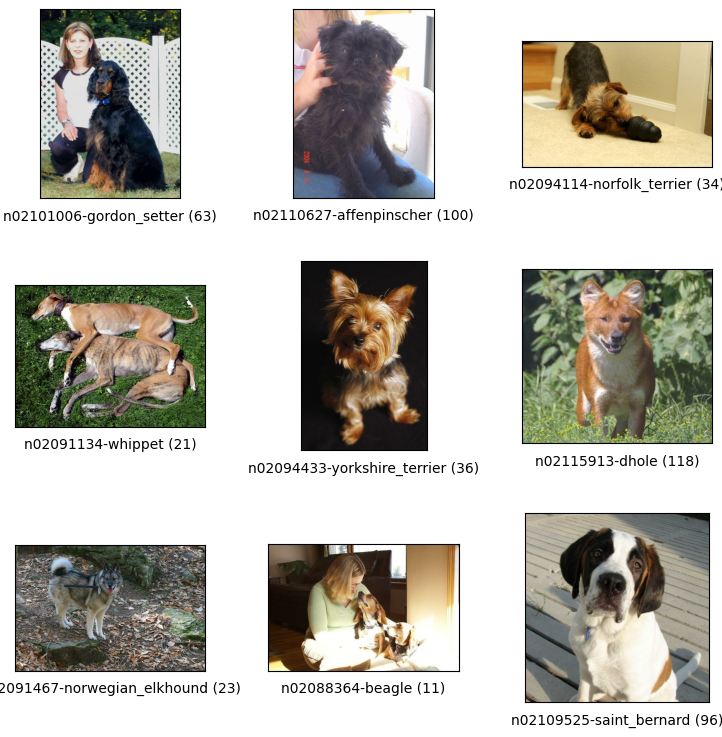

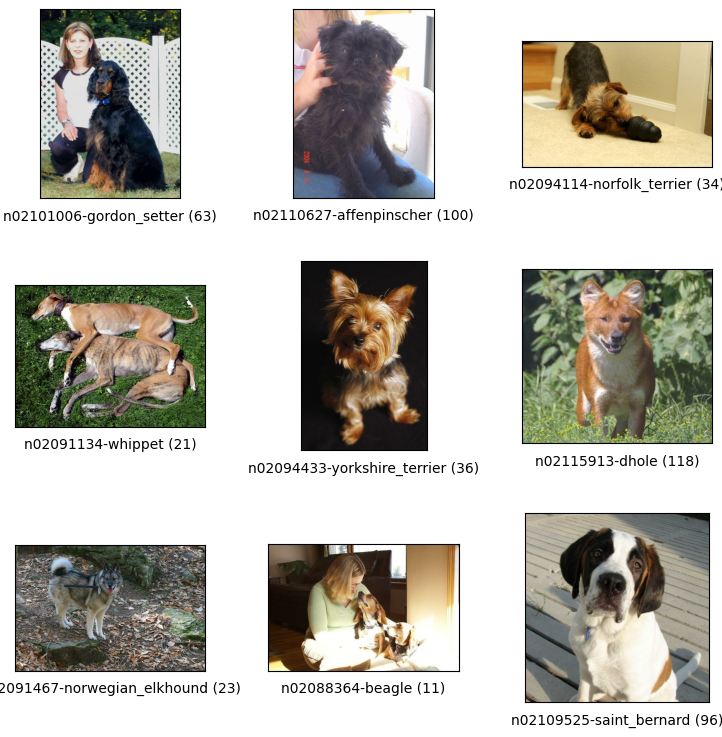

In [78]:
num_classes = ds_info.features["label"].num_classes
print('num_classes:', num_classes)
tfds.show_examples(ds_train, ds_info)


In [71]:
# image clip의 좌표값 반환
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))
    
    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels



In [53]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label



def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False):
    ds = ds.map(normalize_and_resize_img, num_parallel_calls=2)
    if not is_test and with_aug:
        ds = ds.map(augment)
    
    ds = ds.batch(batch_size)

    if not is_test and with_cutmix:
        ds = ds.map(cutmix, num_parallel_calls=2)
    else:
        ds = ds.map(onehot, num_parallel_calls=2)
    
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)

    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

### 2. 모델 만들기
---
앞서 만들었던 것처럼 비교 실험을 위한 모델 두 개를 만들어 주세요. 모델은 ResNet-50을 사용합시다.

In [104]:
def get_resnet50_model():
    resnet50_model = keras.models.Sequential([
        keras.applications.resnet.ResNet50(
            include_top=False,
            weights='imagenet',
            input_shape=(224,224,3),
            pooling='avg',
        ),
        keras.layers.Dense(num_classes, activation='softmax')
    ])

    resnet50_model.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.legacy.SGD(lr=0.01),
        metrics=['accuracy'],
    )
    return resnet50_model

In [105]:
resnet50_model = get_resnet50_model()
resnet50_model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_5 (Dense)             (None, 120)               245880    
                                                                 
Total params: 23,833,592
Trainable params: 23,780,472
Non-trainable params: 53,120
_________________________________________________________________


/Users/louan/.pyenv/versions/3.9.13/envs/img/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


### 3. 모델 훈련하기
---
모델을 훈련시켜 주세요.

주의!! 위에서 만든 CutMix나 Mixup을 사용하기 위해서는 앞에서 resnet50과 aug_resnet50을 훈련하는 데 사용했던 sparse_categorical_crossentropy() 대신 categorical_crossentropy()를 사용해 주세요!

Q. sparse_categorical_crossentropy()를 사용하지 못하는 이유가 뭘까요?
<details>
    <summary>정답 확인</summary>
    우리가 cutmix(), mixup()을 구현하면서 label의 mix 때문에 더이상 label이 스칼라값을 가지지 못하고 One-Hot 벡터 형태로 변환되었기 때문
</details>

In [87]:
#EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수
EPOCH = 3
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_test_no_aug = apply_normalize_on_dataset(ds_test, is_test=True)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)

In [80]:
import matplotlib.pyplot as plt

# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

In [88]:
ds_train_aug_cutmix = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=True)

In [106]:
# augmentation 적용하지 않은 데이터셋 사용
history_resnet50_no_aug = resnet50_model.fit(
    ds_train_no_aug,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test_no_aug,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/3


2023-02-26 10:57:01.803635: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


750/750 [==============================] - ETA: 0s - loss: 2.2458 - accuracy: 0.4388

2023-02-26 11:04:19.714113: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


750/750 [==============================] - 542s 701ms/step - loss: 2.2458 - accuracy: 0.4388 - val_loss: 3.3583 - val_accuracy: 0.2088
Epoch 2/3
750/750 [==============================] - 575s 767ms/step - loss: 0.7883 - accuracy: 0.7789 - val_loss: 1.1326 - val_accuracy: 0.6734
Epoch 3/3
750/750 [==============================] - 582s 776ms/step - loss: 0.3237 - accuracy: 0.9200 - val_loss: 0.9427 - val_accuracy: 0.7239


In [107]:
# augmentation 적용한 데이터 사용
resnet50_model = get_resnet50_model()
history_resnet50_aug = resnet50_model.fit(
    ds_train_aug, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test_no_aug,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/3


2023-02-26 11:42:41.424536: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


750/750 [==============================] - ETA: 0s - loss: 2.2812 - accuracy: 0.4268

2023-02-26 11:50:06.872003: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


750/750 [==============================] - 549s 716ms/step - loss: 2.2812 - accuracy: 0.4268 - val_loss: 2.9891 - val_accuracy: 0.2734
Epoch 2/3
750/750 [==============================] - 559s 746ms/step - loss: 0.9711 - accuracy: 0.7230 - val_loss: 1.2801 - val_accuracy: 0.6364
Epoch 3/3
750/750 [==============================] - 561s 747ms/step - loss: 0.5919 - accuracy: 0.8321 - val_loss: 1.1362 - val_accuracy: 0.6725


In [108]:
resnet50_model = get_resnet50_model()
history_resnet50_aug_cutmix = resnet50_model.fit(
    ds_train_aug_cutmix, # augmentation + cutmix
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test_no_aug,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/3


2023-02-26 12:10:32.520429: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


750/750 [==============================] - ETA: 0s - loss: 3.8855 - accuracy: 0.1956

2023-02-26 12:18:29.494229: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


750/750 [==============================] - 588s 771ms/step - loss: 3.8855 - accuracy: 0.1956 - val_loss: 2.9873 - val_accuracy: 0.2633
Epoch 2/3
750/750 [==============================] - 582s 776ms/step - loss: 3.0596 - accuracy: 0.3973 - val_loss: 1.8651 - val_accuracy: 0.5003
Epoch 3/3
750/750 [==============================] - 594s 791ms/step - loss: 2.7776 - accuracy: 0.4832 - val_loss: 1.4732 - val_accuracy: 0.5965


### 4. 훈련 과정 시각화하기
---
훈련 과정의 히스토리를 그래프로 시각화해 주세요.

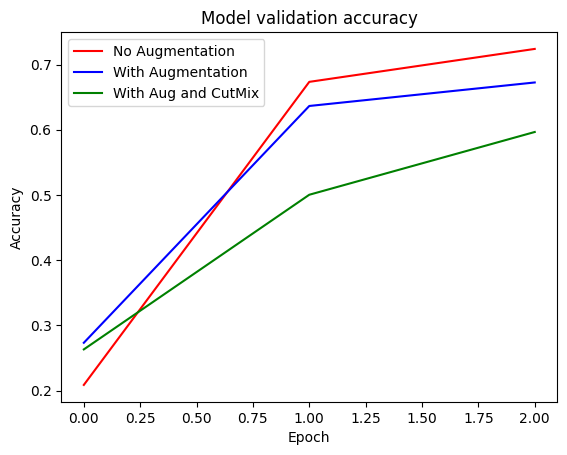

In [109]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_aug_cutmix.history['val_accuracy'], 'g')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With Aug and CutMix'], loc='upper left')
plt.show()

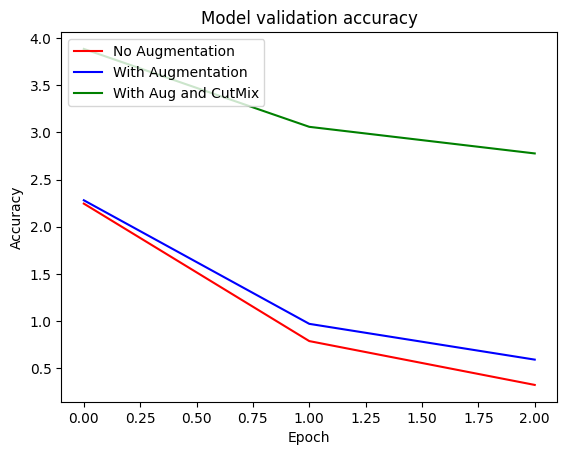

In [110]:
plt.plot(history_resnet50_no_aug.history['loss'], 'r')
plt.plot(history_resnet50_aug.history['loss'], 'b')
plt.plot(history_resnet50_aug_cutmix.history['loss'], 'g')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With Aug and CutMix'], loc='upper left')
plt.show()

### 5. Augmentation에 의한 모델 성능 비교
---
No Augmentation, 기본 Augmentation, 기본 + CutMix 적용, 기본 + Mixup 적용 이상 4가지 경우의 데이터셋에 대해 훈련된 ResNet50 분류기의 견종 분류 정확도 성능을 비교해 보고, Augmentation 방법들의 영향도에 대해 분석해 보세요.

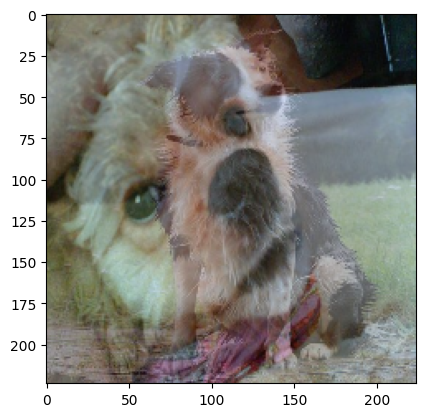

tf.Tensor(
[0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.6580249 0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.3419751 0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.      

In [114]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
plt.show()
print(mixed_label)

In [115]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [111]:
def apply_normalize_on_dataset_2(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(normalize_and_resize_img, num_parallel_calls=2)
    if not is_test and with_aug:
        ds = ds.map(augment)
    
    ds = ds.batch(batch_size)

    if not is_test and not with_mixup and with_cutmix:
        ds = ds.map(cutmix, num_parallel_calls=2)
    elif not is_test and not with_cutmix and with_mixup:
        ds = ds.map(mixup, num_parallel_calls=2)
    else:
        ds = ds.map(onehot, num_parallel_calls=2)
    
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)

    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [116]:
ds_train_aug_mixup = apply_normalize_on_dataset_2(ds_train, with_aug=True, with_mixup=True)

In [117]:
EPOCH = 10
resnet50_model = get_resnet50_model()
history_resnet50_no_aug = resnet50_model.fit(
    ds_train_no_aug, # augmentation + cutmix
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test_no_aug,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10


/Users/louan/.pyenv/versions/3.9.13/envs/img/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
2023-02-26 17:48:48.573470: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


750/750 [==============================] - ETA: 0s - loss: 2.2102 - accuracy: 0.4476

2023-02-26 17:56:17.709856: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


750/750 [==============================] - 548s 715ms/step - loss: 2.2102 - accuracy: 0.4476 - val_loss: 3.0399 - val_accuracy: 0.2580
Epoch 2/10
750/750 [==============================] - 538s 717ms/step - loss: 0.7840 - accuracy: 0.7832 - val_loss: 1.1794 - val_accuracy: 0.6539
Epoch 3/10
750/750 [==============================] - 548s 730ms/step - loss: 0.3110 - accuracy: 0.9273 - val_loss: 0.9991 - val_accuracy: 0.7090
Epoch 4/10
750/750 [==============================] - 554s 738ms/step - loss: 0.1173 - accuracy: 0.9821 - val_loss: 0.9210 - val_accuracy: 0.7322
Epoch 5/10
750/750 [==============================] - 558s 744ms/step - loss: 0.0480 - accuracy: 0.9961 - val_loss: 0.9179 - val_accuracy: 0.7362
Epoch 6/10
750/750 [==============================] - 3473s 5s/step - loss: 0.0284 - accuracy: 0.9980 - val_loss: 0.9377 - val_accuracy: 0.7374
Epoch 7/10
750/750 [==============================] - 524s 698ms/step - loss: 0.0179 - accuracy: 0.9990 - val_loss: 0.9303 - val_accuracy

In [118]:
resnet50_model = get_resnet50_model()
history_resnet50_aug = resnet50_model.fit(
    ds_train_aug, # augmentation + cutmix
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test_no_aug,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10


2023-02-26 20:23:47.286399: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


750/750 [==============================] - ETA: 0s - loss: 2.2890 - accuracy: 0.4277

2023-02-26 20:31:26.388542: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


750/750 [==============================] - 570s 741ms/step - loss: 2.2890 - accuracy: 0.4277 - val_loss: 2.6878 - val_accuracy: 0.3109
Epoch 2/10
750/750 [==============================] - 559s 746ms/step - loss: 1.0215 - accuracy: 0.7097 - val_loss: 1.1824 - val_accuracy: 0.6576
Epoch 3/10
750/750 [==============================] - 3946s 5s/step - loss: 0.5990 - accuracy: 0.8277 - val_loss: 1.1544 - val_accuracy: 0.6725
Epoch 4/10
750/750 [==============================] - 2275s 3s/step - loss: 0.3773 - accuracy: 0.8994 - val_loss: 1.0209 - val_accuracy: 0.7024
Epoch 5/10
750/750 [==============================] - 540s 720ms/step - loss: 0.2318 - accuracy: 0.9431 - val_loss: 1.0914 - val_accuracy: 0.6943
Epoch 6/10
750/750 [==============================] - 552s 736ms/step - loss: 0.1342 - accuracy: 0.9740 - val_loss: 1.0038 - val_accuracy: 0.7235
Epoch 7/10
750/750 [==============================] - 560s 747ms/step - loss: 0.0921 - accuracy: 0.9838 - val_loss: 0.9910 - val_accuracy: 

In [119]:
resnet50_model = get_resnet50_model()
history_resnet50_aug_cutmix = resnet50_model.fit(
    ds_train_aug_cutmix, # augmentation + cutmix
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test_no_aug,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10


2023-02-26 23:22:35.631246: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


750/750 [==============================] - ETA: 0s - loss: 3.9152 - accuracy: 0.1956

2023-02-26 23:50:58.609991: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


750/750 [==============================] - 1801s 2s/step - loss: 3.9152 - accuracy: 0.1956 - val_loss: 2.9899 - val_accuracy: 0.2493
Epoch 2/10
750/750 [==============================] - 552s 736ms/step - loss: 3.0390 - accuracy: 0.3934 - val_loss: 1.4392 - val_accuracy: 0.5981
Epoch 3/10
750/750 [==============================] - 572s 762ms/step - loss: 2.8129 - accuracy: 0.4758 - val_loss: 1.2846 - val_accuracy: 0.6421
Epoch 4/10
750/750 [==============================] - 1116s 1s/step - loss: 2.6045 - accuracy: 0.5397 - val_loss: 1.1889 - val_accuracy: 0.6679
Epoch 5/10
750/750 [==============================] - 543s 724ms/step - loss: 2.4901 - accuracy: 0.5709 - val_loss: 1.1711 - val_accuracy: 0.6798
Epoch 6/10
750/750 [==============================] - 584s 779ms/step - loss: 2.3908 - accuracy: 0.6051 - val_loss: 1.2652 - val_accuracy: 0.6571
Epoch 7/10
750/750 [==============================] - 609s 812ms/step - loss: 2.2988 - accuracy: 0.6288 - val_loss: 1.2060 - val_accuracy: 

In [120]:
resnet50_model = get_resnet50_model()
history_resnet50_aug_mixup = resnet50_model.fit(
    ds_train_aug_mixup, # augmentation + cutmix
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test_no_aug,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10


2023-02-27 01:42:26.789852: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


750/750 [==============================] - ETA: 0s - loss: 3.7247 - accuracy: 0.2400

2023-02-27 01:50:18.274773: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


750/750 [==============================] - 587s 762ms/step - loss: 3.7247 - accuracy: 0.2400 - val_loss: 4.0025 - val_accuracy: 0.1399
Epoch 2/10
750/750 [==============================] - 606s 808ms/step - loss: 2.9302 - accuracy: 0.4492 - val_loss: 1.4277 - val_accuracy: 0.5903
Epoch 3/10
750/750 [==============================] - 1597s 2s/step - loss: 2.6993 - accuracy: 0.5300 - val_loss: 1.7084 - val_accuracy: 0.5350
Epoch 4/10
750/750 [==============================] - 9499s 13s/step - loss: 2.5474 - accuracy: 0.5972 - val_loss: 1.3960 - val_accuracy: 0.6177
Epoch 5/10
750/750 [==============================] - 1911s 3s/step - loss: 2.4105 - accuracy: 0.6432 - val_loss: 1.4330 - val_accuracy: 0.5999
Epoch 6/10
750/750 [==============================] - 560s 747ms/step - loss: 2.3393 - accuracy: 0.6703 - val_loss: 1.3094 - val_accuracy: 0.6374
Epoch 7/10
750/750 [==============================] - 573s 764ms/step - loss: 2.2311 - accuracy: 0.7062 - val_loss: 1.1882 - val_accuracy: 0

## 결과 시각화

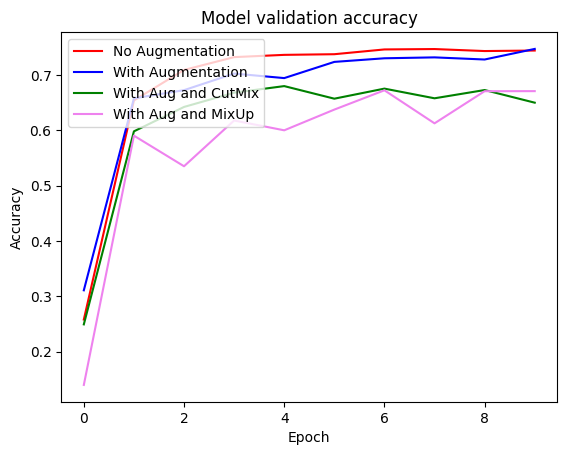

In [122]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_aug_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_aug_mixup.history['val_accuracy'], 'violet')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With Aug and CutMix', 'With Aug and MixUp'], loc='upper left')
plt.show()

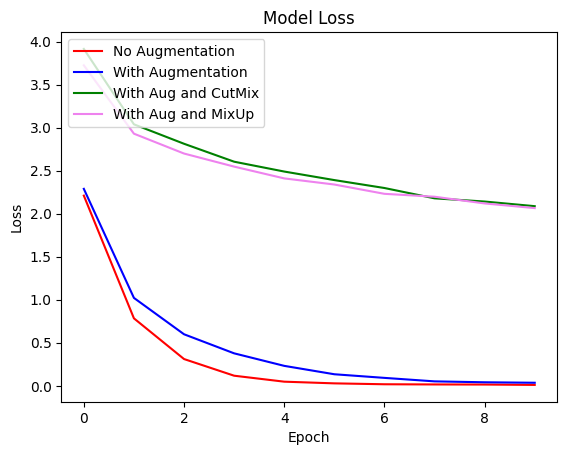

In [125]:
plt.plot(history_resnet50_no_aug.history['loss'], 'r')
plt.plot(history_resnet50_aug.history['loss'], 'b')
plt.plot(history_resnet50_aug_cutmix.history['loss'], 'g')
plt.plot(history_resnet50_aug_mixup.history['loss'], 'violet')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With Aug and CutMix', 'With Aug and MixUp'], loc='upper left')
plt.show()

# 결론
- Aumentation이 없는 경우 4~5 epoch을 기준으로 loss 가 거의 변동이 없음. Validation Accuracy역시 비슷함
- augmentation을 적용하는 경우 augmentation이 적용되지 않은 경우에 비해 그 감소폭이 낮음. 대략 8 Epoch 부근에서 loss의 변화가 없으며, 10 Epoch을 기준으로 최초로 validation accuracy가 no aug보다 높아진 것을 확인할 수 있음
- 그래프의 기울기와 추세로보아 좀 더 epoch이 많아질 경우, 좀 더 높은 validation accuracy를 기대할 수 있을 것으로 보임
- mixup과 cutmix는 두 기법 모두 비슷한 경향을 보이나 no aug데이터에 비해 전반적으로 높은 loss와 낮은 validation accuracy를 보임. 또한 validation accuracy의 경우 다소 불안정한 흐름을 보이기도 함. 그러나 추세적으로 지속적으로 하향하고 있어 좀 더 많은 epoch을 돌린다면 결과가 바뀔 수 있는 가능성이 있을 것으로 보임